<a href="https://colab.research.google.com/github/luisleo526/TransferLearning-Classification/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# -----------------------------------
# Input the data directory from your Google Drive
DATA_DIR = "/content/drive/MyDrive/train"
# -----------------------------------
SEED = 17
BATCH_SIZE = 8
NUM_WORKERS = 2
# -----------------------------------
# DO NOT CHANGE if using pretrinaed NtsNet, https://github.com/nicolalandro/ntsnet-cub200 (ResNet50-based)
RESIZE_RESOLUTION = 600
TARGET_RESOLUTION = 448
# -----------------------------------
LEARNING_RATE = 3e-4
EPOCHS = 10

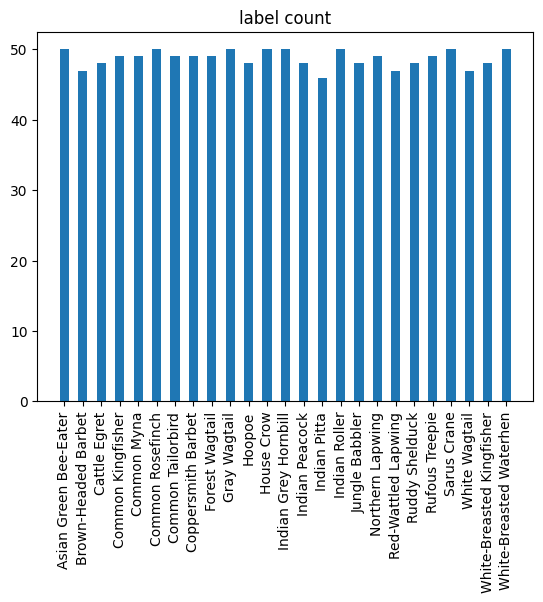

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
import torch
import matplotlib.pyplot as plt

dataset = ImageFolder(DATA_DIR, transform = Compose([ToTensor(), Resize((RESIZE_RESOLUTION, RESIZE_RESOLUTION), antialias=True)]))
dataset.idx_to_class = {v:k for k,v in dataset.class_to_idx.items()}

labels, labels_count = map(lambda x: x.tolist(), torch.unique(torch.tensor(dataset.targets), return_counts=True))
labels = [dataset.idx_to_class[x] for x in labels]

plt.bar(labels, labels_count, width=0.5)
plt.title('label count')
_ = plt.xticks(fontsize=10, rotation=90)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader
from functools import partial
from torchvision.transforms import RandomCrop, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, Normalize, RandomApply

def collate_fn(samples, transform):
  images = []
  labels = []
  for image_tensor, image_label in samples:
    images.append(image_tensor)
    labels.append(image_label)
  return torch.tensor(labels, dtype=torch.uint8), transform(torch.stack(images))

# ColorJitter is a very strong augmentation.
train_transform = Compose([
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    RandomCrop((TARGET_RESOLUTION, TARGET_RESOLUTION)),
    RandomHorizontalFlip(0.5),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = Compose([
    CenterCrop((TARGET_RESOLUTION, TARGET_RESOLUTION)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=True, random_state=SEED)

train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_indices), 
                collate_fn=partial(collate_fn, transform=train_transform), num_workers=NUM_WORKERS, 
                pin_memory=True, pin_memory_device='cuda')
test_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_indices),
                collate_fn=partial(collate_fn, transform=test_transform), num_workers=NUM_WORKERS,
                pin_memory=True, pin_memory_device='cuda')


In [ ]:
from torchvision.models import efficientnet_b0
import torch.nn as nn


class BirdClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # Source: NtsNet, https://github.com/nicolalandro/ntsnet-cub200 (ResNet50-based)
    backbone = torch.hub.load('nicolalandro/ntsnet-cub200', 'ntsnet', pretrained=True, 
                  **{'topN': 6, 'device':'cuda', 'num_classes': 200})
    # (1): For whole usage
    self.backbone = backbone
    # (2): For partial usage (ResNet weights only)
    # self.backbone = backbone.pretrained_model

    # Add new layer for transfer learning
    # -----------------------------------------------
    self.fc = nn.Sequential(           
        nn.Linear(200, 1024),
        nn.ReLU(), 
        nn.Linear(1024, len(labels))
    )
    # -----------------------------------------------

  def forward(self, x):

    # From the sources
    # (1): For whole usage
    _, _, _, y, _, _, _ = self.backbone(x)
    # (2): For partial usage (ResNet weights only)
    # y, _, _ = self.backbone(x)

    return self.fc(y)

model = BirdClassifier()

Using cache found in /root/.cache/torch/hub/nicolalandro_ntsnet-cub200_master


In [ ]:
# Freeze the transfered model
for param in model.parameters():
  param.requires_grad = False

# Unfreeze the appended layer
for param in model.fc.parameters():
  param.requires_grad = True

# Check everything
for name, param in model.named_parameters():
  if param.requires_grad:
    print(f'param name: {name}, shape: {param.shape}')

param name: fc.0.weight, shape: torch.Size([1024, 200])
param name: fc.0.bias, shape: torch.Size([1024])
param name: fc.2.weight, shape: torch.Size([25, 1024])
param name: fc.2.bias, shape: torch.Size([25])


In [ ]:
from torch.nn import Linear, CrossEntropyLoss
from torch.optim.lr_scheduler import LinearLR

optim = torch.optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
scheduler = LinearLR(optim, start_factor=1.0, end_factor=0.01, total_iters=EPOCHS)
loss_fn = CrossEntropyLoss().cuda()

In [ ]:
from tqdm.notebook import tqdm
from argparse import Namespace

model.cuda()
torch.backends.cudnn.benchmark = True
# -----------------------------------------------
# Automatic Mixed Precision (AMP), see https://pytorch.org/docs/stable/notes/amp_examples.html
USE_AMP = True
scaler = torch.cuda.amp.GradScaler()
# -----------------------------------------------

loss_history = Namespace(train=[], test=[])
acc_history = Namespace(train=[], test=[])

pbar = tqdm(total=EPOCHS)
for epoch in range(EPOCHS):

  model.train()
  train_info = Namespace(acc=0, loss=0, n=0)

  for label, image in train_dataloader:

    optim.zero_grad()

    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=USE_AMP):
      label, image = label.to('cuda').contiguous(), image.to('cuda').contiguous()
      output = model(image)
      loss = loss_fn(output, label)

    if USE_AMP:
      scaler.scale(loss).backward()
      scaler.step(optim)
      scaler.update()
    else:
      loss.backward()
      optim.step()

    train_info.loss += loss.item()
    train_info.n += label.shape[0]
    train_info.acc += torch.sum(output.argmax(dim=1) == label).item()

  train_info.loss /= train_info.n
  train_info.acc /= train_info.n
  
  scheduler.step()

  model.eval()
  test_info = Namespace(acc=0, loss=0, n=0)
  
  for label, image in test_dataloader:
    with torch.no_grad():
      label, image = label.to('cuda'), image.to('cuda')
      output = model(image)
      loss = loss_fn(output, label)

    test_info.loss += loss.item()
    test_info.n += label.shape[0]
    test_info.acc += torch.sum(output.argmax(dim=1) == label).item()

  test_info.loss /= test_info.n
  test_info.acc /= test_info.n

  pbar.update(1)
  pbar.set_postfix(train_loss=f"{train_info.loss:.2e}", train_acc=f"{train_info.acc*100:.2f}%",
           test_loss=f"{test_info.loss:.2e}", test_acc=f"{test_info.acc*100:.2f}%")
  
  loss_history.train.append(train_info.loss)
  loss_history.test.append(test_info.loss)

  acc_history.train.append(train_info.acc)
  acc_history.test.append(test_info.acc)

  0%|          | 0/10 [00:00<?, ?it/s]

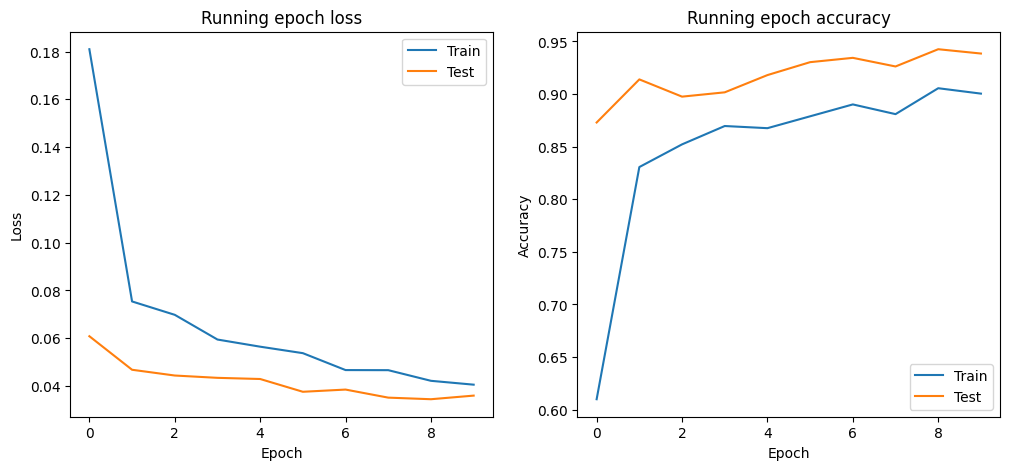

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].plot(loss_history.train, label="Train")
axs[0].plot(loss_history.test, label="Test")
axs[0].set_title("Running epoch loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(acc_history.train, label="Train")
axs[1].plot(acc_history.test, label="Test")
axs[1].set_title("Running epoch accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()